<a href="https://colab.research.google.com/github/AntoninaKOR/RL/blob/main/A2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading and importing libs

In [ ]:
!apt-get install swig
!pip install Image
!pip install autorom
!pip install shimmy
!pip install 'gymnasium[atari]'
#!pip install "gym[atari, accept-rom-license]"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import gymnasium as gym
import numpy as np
import ale_py
import shimmy
from torch.distributions import Categorical
import torch
import torch.nn as nn
import torch.optim as optim

from collections import namedtuple, deque
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)

### Intro
There is a **A2C** algorithm with policy function with based on **Alexnet** (but with other sizes of out_channels and without one conv layer). The algorithm works on MsPacman environment from Gymnasium lib.

It can be intresting to check A2C on more complex environment.

### Task

The playing MsPacman consists of two parts:
* avoiding ghosts
* getting points
At this notebook we will focus on getting points, because avoiding ghosts is more complex task.

So the **main task** is teach the regularly stable get more then 200 points.


#About env

Info about environment: https://ale.farama.org/environments/ms_pacman/

There is how env looks:

Initial observation:


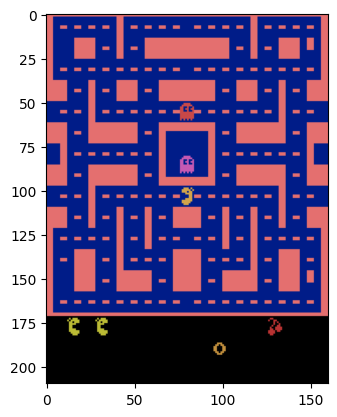

In [ ]:
env = gym.make("ALE/MsPacman-v5",  render_mode="rgb_array", obs_type="grayscale")
env.reset()
print("Initial observation:")
plt.imshow(env.render())

#Memory

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def clear(self):
        self.memory.clear()

##Algorithm
We use algorithm from the book "Foundations of Deep Reinforcement Learning: Theory and Practice in Python" (Addison-Wesley Data & Analytics Series).

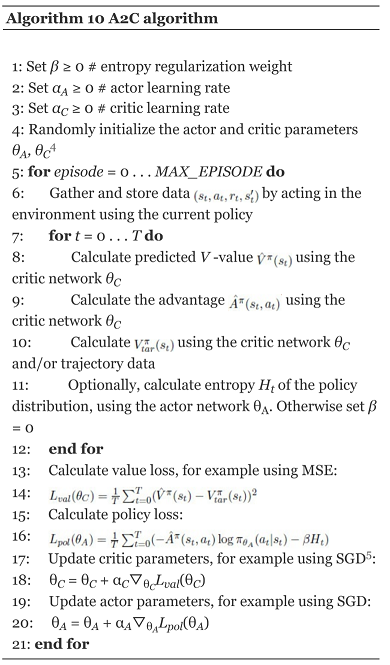

#Actor

In [ ]:
class Actor(nn.Module):
  def __init__(self, out_dim, dropout: float = 0.5):
    super(Actor, self).__init__()
    layers = [
               nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3),
               nn.ReLU(inplace=True),
               nn.MaxPool2d(kernel_size=2),

               nn.Conv2d(6, 18, kernel_size=5, padding=2),
               nn.ReLU(inplace=True),
               nn.MaxPool2d(kernel_size=3, stride=2),

               nn.Conv2d(18, 64, kernel_size=3, padding=1),
               nn.ReLU(inplace=True),
               nn.MaxPool2d(kernel_size=3, stride=2),

               nn.AdaptiveAvgPool2d((6, 6)),

               nn.Flatten(1),
               nn.Dropout(p=dropout),
               nn.Linear(64 * 6 * 6, 1152),
               nn.ReLU(inplace=True),
               nn.Dropout(p=dropout),
               nn.Linear(1152, 64),
               nn.Linear(64,out_features = out_dim)
               ]

    self.model = nn.Sequential(*layers)
    self.optimizer = optim.Adam(self.model.parameters(), lr = 0.001)

  def forward(self, x):
    pdparam = self.model(x)
    return pdparam

#Critic

In [ ]:
class Critic(nn.Module):
  def __init__(self, dropout: float = 0.5):
    super(Critic, self).__init__()
    layers = [ # input (1, 210, 160)
               nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3),
               nn.ReLU(inplace=True),
               nn.MaxPool2d(kernel_size=2),

               nn.Conv2d(6, 18, kernel_size=5, padding=2),
               nn.ReLU(inplace=True),
               nn.MaxPool2d(kernel_size=3, stride=2),

               nn.Conv2d(18, 64, kernel_size=3, padding=1),
               nn.ReLU(inplace=True),
               nn.MaxPool2d(kernel_size=3, stride=2),

               nn.AdaptiveAvgPool2d((6, 6)),

               nn.Flatten(1),
               nn.Dropout(p=dropout),
               nn.Linear(64 * 6 * 6, 1152),
               nn.ReLU(inplace=True),
               nn.Dropout(p=dropout),
               nn.Linear(1152, 64),
               nn.Linear(64,out_features = 1)
               ]

    self.model = nn.Sequential(*layers)
    self.optimizer = optim.Adam(self.model.parameters(), lr = 0.001)

  def forward(self, x):
    pdparam = self.model(x)
    return pdparam

##Initialization

For calculating Advantages we use formula:
$$ A_{NSTEP}(s_t, a_t) = Q^{\pi}(s_t, a_t) - V^{\pi}(s_t) = \sum_{k=o}^n {\gamma}^k r_{t+k} + {\gamma}^{n+1} V^{\pi} (s_{t+n+1}) - V^{\pi}(s_t)$$

For $ V_{tar}$ we use a Monte Carlo estimate.

In [ ]:
class A2C:
  def __init__(self, actor, critic, memory, gamma, beta):
    super(A2C, self).__init__()
    self.actor = actor
    self.critic = critic
    self.gamma = gamma
    self.beta = beta
    self.memory = memory

  def onpolicy_reset(self):
    self.memory.clear()

  def eval_action(self, states):
    #x = torch.from_numpy(np.expand_dims(states,0)).to(torch.float32)
    actions = self.actor.forward(states)
    values = self.critic.forward(states)
    pd = Categorical(logits =actions)
    actions = pd.sample(sample_shape=torch.Size([states.size()[0]]) )
    log_probs = pd.log_prob(actions )
    entropies = pd.entropy()
    entropies = entropies.expand_as(actions)
    return values, log_probs, entropies

  def act(self, state):
    #print(state)
    #x = torch.from_numpy(np.expand_dims(state,0)).to(torch.float32)
    x = state.unsqueeze(0)
    action = self.actor.forward(x)
    pd = Categorical(logits =action)
    action = pd.sample()
    return action.item()

  def train(self, BATCH_SIZE):
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    states = torch.stack(batch.state)
    actions = torch.cat(batch.action)
    rewards = torch.cat(batch.reward)
    v, log_probs, h =  self.eval_action(states)
    v = v.view((v.size()[0],))
    v_d = v.clone().detach()
    # count Q for the n-step advantage function
    Q=0.0
    q=[]
    for t in range(0, len(rewards)-1):
      Q = rewards[t] + self.gamma*v_d[t+1]
      q.append(Q)
    q.append(rewards[-1])
    q = torch.tensor(q, device = device)

    #advantage
    a = q - v_d
    a = (a - a.mean())/a.std()

    # count Vtar using Monte Carlo estimate
    Vtar=0.
    tar = torch.empty(len(rewards)).to(device)
    for t in reversed(range(1, len(rewards))):
      Vtar = rewards[t] + self.gamma * Vtar
      tar[t] = Vtar

    #losses
    loss = nn.MSELoss(reduction= 'mean')
    loss_critic = loss(v.view(tar.shape), tar)

    loss_actor = - log_probs * a - h*self.beta
    #print(torch.sum(loss_actor), (1./len(log_probs))*torch.sum(loss_actor))
    loss_actor = torch.mean(loss_actor)
    #print(loss_critic, loss_actor)
    # Optimize the models
    self.critic.optimizer.zero_grad()
    loss_critic.backward()
    self.critic.optimizer.step()

    self.actor.optimizer.zero_grad()
    loss_actor.backward()
    self.actor.optimizer.step()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##Training

In [ ]:
from IPython import display
from tqdm import trange, tqdm
display.clear_output(wait=True)
MAX_STEP=2_000
N=2_000
GAMMA=0.99
B_SIZE = 3
BETA = 0.1
rewards=[]
steps=[]
n_actions = 5
memory = ReplayMemory(MAX_STEP)

actor = Actor(n_actions).to(device)
critic = Critic().to(device)
a2c = A2C(actor, critic, memory, GAMMA, BETA)

loop = trange(N, leave=True)
for epi in loop:
  state, info = env.reset()
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)/256.
  rew=0
  t = 0
  while t<MAX_STEP:
    t+=1
    action = a2c.act(state)
    new_s, reward, terminated, truncated, _ = env.step(action)
    rew+=reward
    reward = torch.tensor([reward], device=device)
    action = torch.tensor([action], device=device)
    memory.push(state, action, reward)
    env.render()
    state = torch.tensor(new_s, dtype=torch.float32, device=device).unsqueeze(0)/256
    if terminated or truncated:
      break
  a2c.train(t)
  rewards.append(rew)
  steps.append(t+1)
  if epi%100==0:
    tqdm.write(f'Episode {epi}, count of steps:{t+1}, total_reward:{rew}')

  0%|          | 1/500 [00:01<09:57,  1.20s/it]

Episode 0, count of steps:438, total_reward:250.0


 20%|██        | 101/500 [02:39<09:38,  1.45s/it]

Episode 100, count of steps:320, total_reward:130.0


 40%|████      | 201/500 [05:21<08:08,  1.64s/it]

Episode 200, count of steps:508, total_reward:310.0


 60%|██████    | 301/500 [08:01<05:16,  1.59s/it]

Episode 300, count of steps:708, total_reward:540.0


 80%|████████  | 401/500 [10:46<02:41,  1.63s/it]

Episode 400, count of steps:362, total_reward:170.0


100%|██████████| 500/500 [13:33<00:00,  1.63s/it]


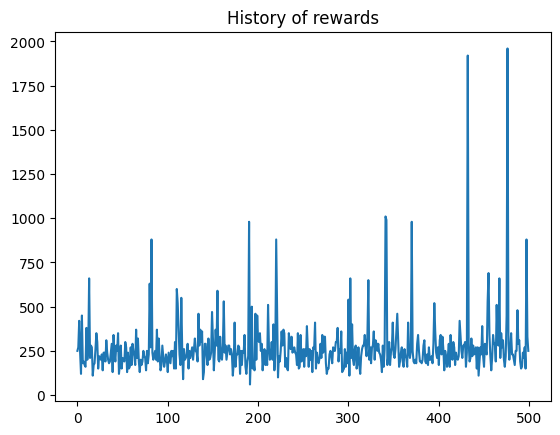

In [ ]:
plt.plot(rewards)
plt.title("History of rewards")
plt.show()

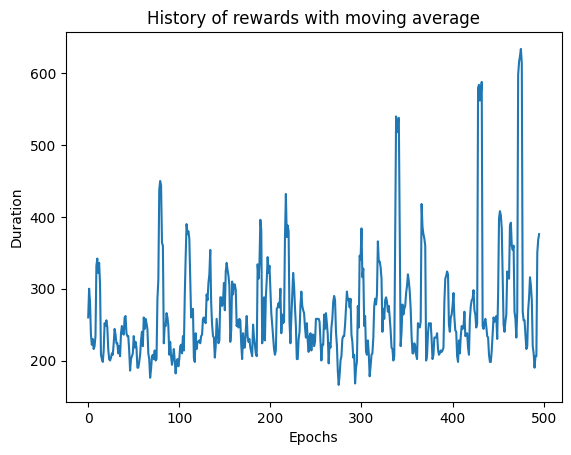

In [ ]:
plt.plot([(rewards[i]+rewards[i-1]+ rewards[i+1] + rewards[i+2] + rewards[i-2])/5 for i in range(2, len(steps)-2)])
plt.title("History of rewards with moving average")
plt.xlabel("Epochs")
plt.ylabel("Duration")
plt.show()

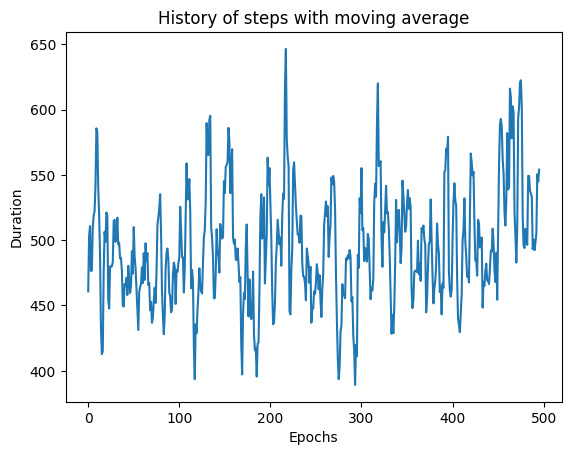

In [ ]:
plt.plot([(steps[i]+steps[i-1]+ steps[i+1] + steps[i+2] + steps[i-2])/5 for i in range(2, len(steps)-2)])
plt.title("History of steps with moving average")
plt.xlabel("Epochs")
plt.ylabel("Duration")
plt.show()

#Let's look how the agent acts

Now we can look how fitted model moves online.

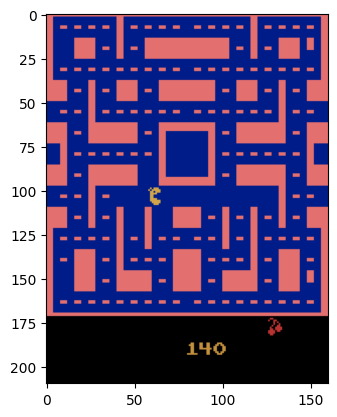

In [ ]:
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)/256.
for t in range(1000):
  action = a2c.act(state)
  new_s, r, terminated, truncated, _ = env.step(action)
  plt.imshow(env.render())
  display.display(plt.gcf())
  display.clear_output(wait=True)
  if terminated or truncated:
    break